In [1]:
%matplotlib inline

In [2]:
import sqlite3
import numpy as np
import pandas as pd
import eofs.standard as eofs
import pylab as plt
import scipy.stats as stats
import scipy.signal as signal
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.path as mplpath
import seaborn as sns
import xarray as xr
import cartopy.util
import cartopy.crs as ccrs
import tools

In [3]:
# plt.style.use("coolbeans")
sns.set_style("whitegrid")
mpl.rcParams.update({'font.size': 10})
np.random.seed(123)

In [4]:
DB_PATH = "./data/stationdb.sqlite"
TCR_PATH = "./data/erai.npz"
ERSST_PATH = "./data/oisst.npz"
WESTOFLON = -104
EASTOFLON = -125
WATER_YEAR = {"low": 1983,
              "high": 2011}
WY_RANGE = np.arange(WATER_YEAR["low"], WATER_YEAR["high"] + 1)
CAL_YEAR = {"low": WATER_YEAR["low"] - 1,
            "high": WATER_YEAR["high"]}

In [5]:
# Grab data from SQLITE3 DB.
target_stations = [i for i in tools.check_monthly(DB_PATH, CAL_YEAR["low"], CAL_YEAR["high"], WESTOFLON, EASTOFLON)]
conn = sqlite3.connect(DB_PATH)
sql_query = """SELECT stationid, year, meanCFS FROM StationWY 
               WHERE year <= {wy_high} AND year >= {wy_low} AND stationid IN ({seq}) 
               GROUP BY stationid, year 
               ORDER BY stationid, year ASC""".format(wy_low = str(WATER_YEAR["low"]), 
                                                      wy_high = str(WATER_YEAR["high"]), 
                                                      seq = ",".join(["?"] * len(target_stations)))
raw = pd.read_sql(sql_query, conn, params = target_stations, index_col = ["year", "stationid"])
conn.close()

In [6]:
# raw.unstack(level = -1).to_csv('streamflow_1975.csv')

In [7]:
# Get corresponding latitude and longitude.
conn = sqlite3.connect(DB_PATH)
sql_query = """SELECT stationid, latgage, longage FROM StationInfo 
               WHERE stationid IN ({seq}) 
               ORDER BY stationid ASC""".format(seq = ",".join(["?"] * len(target_stations)))
latlon = pd.read_sql(sql_query, conn, params = target_stations)
conn.close()

## Streamflow gage map

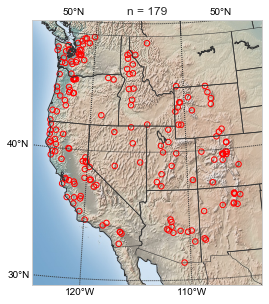

In [8]:
out = tools.plot_gagesmap(latlon["latgage"].as_matrix(), latlon["longage"].as_matrix())

## KS-Test for non-gamma distributed streamflow

Series([], Name: meanCFS, dtype: float64)


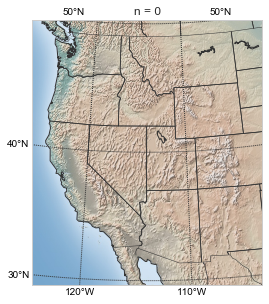

In [9]:
kspvals = raw.groupby(level = 'stationid')['meanCFS'].aggregate(tools.adj_gamma_kstest)
# latlon of gages which do not fit gamma.
print(kspvals[kspvals <= 0.05])
non_gamma = latlon[latlon['stationid'].isin(kspvals[kspvals <= 0.05].index.values)]
out = tools.plot_gagesmap(non_gamma["latgage"].as_matrix(), non_gamma["longage"].as_matrix())

## Test for peak runoff

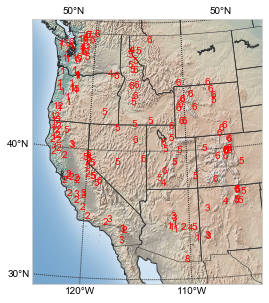

In [10]:
conn = sqlite3.connect(DB_PATH)
sql_query = """SELECT stationid, year, month, meanCFS FROM StationMonthly 
               WHERE year <= {cal_high} AND year >= {cal_low} AND stationid IN ({seq}) 
               ORDER BY stationid, year, month ASC""".format(cal_low = str(CAL_YEAR["low"]), 
                                                             cal_high = str(CAL_YEAR["high"]), 
                                                             seq = ",".join(["?"] * len(target_stations)))
monthly_flows = pd.read_sql(sql_query, conn, params = target_stations, index_col = ['stationid', 'year', 'month'])
conn.close()
monthly_mean = monthly_flows.groupby(level = ['stationid', 'month']).mean()
# Get month with max flow for each station.
max_month = monthly_mean.groupby(level = 'stationid').idxmax()['meanCFS'].apply(lambda a: a[1])

# Join max months with latlon data.
max_month = latlon.join(max_month, on = 'stationid')

# Plot data on map
fig = plt.figure(figsize = (4, 6))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
m = Basemap(width = 2000000, height = 2300000, 
            resolution = 'l', projection = 'stere', 
            lat_ts = 40.0, 
            lat_0 = 40.0, lon_0 = -114.0)
m.drawcoastlines(color = "#333333")
m.drawstates(linewidth = 0.7, color = "#333333")
m.drawcountries(color = "#333333")
m.shadedrelief()
parallels = np.arange(0., 81, 10)
m.drawparallels(parallels, labels = [True, False, True, False], color = "#333333")
meridians = np.arange(10., 351., 10)
m.drawmeridians(meridians, labels = [False, True, False, True], color = "#333333")
for r in max_month.iterrows():
    x, y = m(r[1]['longage'], r[1]['latgage'])  # A bit slow. Should do all at once.
    plt.text(x, y, r[1]['meanCFS'], color = 'r')
plt.show()

## Standardize streamflow

In [11]:
parsed = raw.groupby(level = "stationid")["meanCFS"].transform(tools.spigamma)
# parsed = raw.groupby(level = "stationid")["meanCFS"].transform(tools.zscore)

## Basic North Test scree plot

In [12]:
# Interesting iterations are:
# 1) standardized, correlation or covariance (`center = True` in this case).
# 2) Non-standardized correlation.
examine_modes = 10
solver = eofs.Eof(parsed.unstack().as_matrix(), center = False)
eof = solver.eofsAsCovariance(neofs = examine_modes)
pc = solver.pcs(npcs = examine_modes, pcscaling = 1)
frac_var = solver.varianceFraction(examine_modes)

In [13]:
pc = pd.DataFrame(pc,
                  columns = ['PC' + str(i + 1) for i in range(examine_modes)],
                  index = pd.Index(WY_RANGE, name = 'wy'))
# pc.to_csv('pc_1983.csv', index = True)

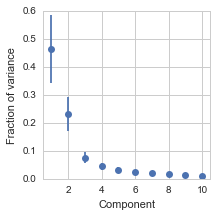

In [14]:
out = tools.plot_northtest(solver, nmodes = examine_modes)

In [15]:
retain_modes = 2

## PC time series from leading components

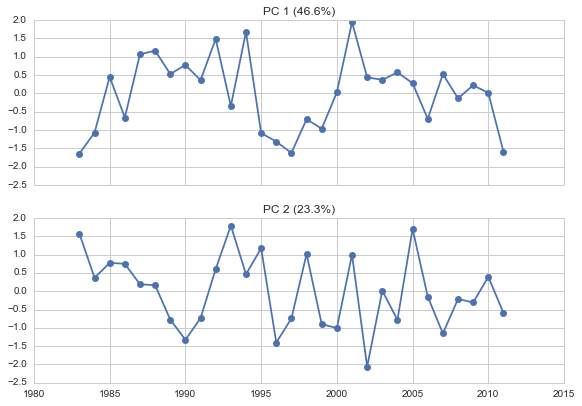

In [16]:
out = tools.plot_pc(solver, yr = WY_RANGE, nmodes = retain_modes)

## Leading EOFs mapped as covariance

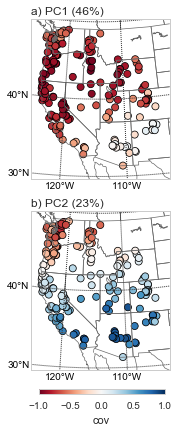

In [17]:
out = tools.plot_eof(solver, 
                     lat = latlon["latgage"].as_matrix(),
                     lon = latlon["longage"].as_matrix(), 
                     nmodes = retain_modes,
                     figure_size = (2.5, 6.5))
# plt.savefig("./plots/fig1.eps")

## Leading two modes as vectors

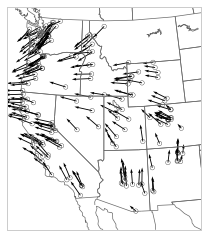

In [18]:
# Linear regression of the first two leading PCs onto the gage time series to get regression coefficients.
rcoef1 = parsed.groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc.PC1, x)[0])
rcoef2 = parsed.groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc.PC2, x)[0])

out = tools.plot_vectormap(coef1 = rcoef1, coef2 = rcoef2,
                           lat = latlon["latgage"].as_matrix(),
                           lon = latlon["longage"].as_matrix())

# New point correlation maps with cartopy

# Point correlation maps

In [19]:
def point_corr(da, pc_df):
    season = ['JJA-1', 'SON-1', 'DJF', 'MAM']
    pc_dim = ['PC1', 'PC2']
    out_lat = da['lat'].values
    out_lon = da['lon'].values
    out_shape = (len(pc_dim), len(season), len(out_lat), len(out_lon))
    out = xr.Dataset({'r': (['PC','season', 'lat', 'lon'], np.zeros(out_shape)),
                      'p': (['PC','season', 'lat', 'lon'], np.zeros(out_shape))},
                    coords = {'PC': pc_dim,
                              'season': season,
                              'lon': out_lon,
                              'lat': out_lat})
    for pc_i in pc_dim:
        for seas_i in season:
            r, p = tools.pearson_corr(pc_df[pc_i], da.sel(season = seas_i).values)
            out['r'].loc[dict(PC = pc_i, season= seas_i)] = r
            out['p'].loc[dict(PC = pc_i, season= seas_i)] = p
    return out

def plot_point_corr(ds, map_type):
    """
    """
    assert map_type in ['north_hemisphere', 'global']

    proj = {'north_hemisphere': ccrs.LambertAzimuthalEqualArea(central_longitude = -160,
                                                               central_latitude = 90),
            'global': ccrs.Robinson(central_longitude = -160)}
    subplot_kwargs = {'north_hemisphere': {'adjust': {'right': 1 - 0.15},
                                         'add_axes': [1 - 0.17, 0.1, 0.017, 0.7],
                                         'colorbar': {'orientation': 'vertical'}},
                      'global': {'adjust': {'bottom': 0.15},
                                 'add_axes': [0.17, 0.1, 0.7, 0.01],
                                 'colorbar': {'orientation': 'horizontal'}}
                    }

    pc_dim = ds['PC'].values
    season = ds['season'].values

    divs = np.linspace(-1, 1, 11)
    alpha=[0, 0.05, 1]

    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mplpath.Path(verts * radius + center)

    plot_meta = [{'season': 'JJA-1',
                  'PC':     'PC1',
                  'title':  'a) PC1: JJA'},
                 {'season': 'JJA-1',
                  'PC':     'PC2',
                  'title':  'e) PC2: JJA'},
                 {'season': 'SON-1',
                  'PC':     'PC1',
                  'title':  'b) PC1: SON'},
                 {'season': 'SON-1',
                  'PC':     'PC2',
                  'title':  'f) PC2: SON'},
                 {'season': 'DJF',
                  'PC':     'PC1',
                  'title':  'c) PC1: DJF'},
                 {'season': 'DJF',
                  'PC':     'PC2',
                  'title':  'g) PC2: DJF'},
                 {'season': 'MAM',
                  'PC':     'PC1',
                  'title':  'd) PC1: MAM'},
                 {'season': 'MAM',
                  'PC':     'PC2',
                  'title':  'h) PC2: MAM'}]

    fig = plt.figure(figsize = (5.5, 8))
    for i in range(len(pc_dim) * len(season)):
        i_season = plot_meta[i]['season']
        i_pc = plot_meta[i]['PC']
        i_title = plot_meta[i]['title']
        ax = fig.add_subplot(len(season), len(pc_dim), i + 1, projection = proj[map_type])
        ax.coastlines()
        ax.gridlines(linestyle = 'dotted', color = '#696969', linewidth = 0.5)
        ds_crop = ds.sel(season = i_season, PC = i_pc)
        if map_type == 'north_hemisphere':
            ax.set_boundary(circle, transform = ax.transAxes)
            ds_crop = ds_crop.sel(lat = slice(90, 0))
        r_crop = ds_crop['r']
        p_crop = ds_crop['p']
        r_cyc, lon_cyc = cartopy.util.add_cyclic_point(r_crop.values, 
                                                       coord = r_crop['lon'].values, 
                                                       axis = -1)
        p_cyc, lon_cyc = cartopy.util.add_cyclic_point(p_crop.values, 
                                                       coord = p_crop['lon'].values, 
                                                       axis = -1)
        ctf1 = ax.contourf(lon_cyc, r_crop.lat.values, r_cyc, divs, 
                           cmap = plt.cm.RdBu, 
                           transform = ccrs.PlateCarree())
        ctf2 = ax.contourf(lon_cyc, p_crop.lat.values, p_cyc, alpha, 
                           colors = 'none', 
                           hatches = ['....', None], 
                           transform = ccrs.PlateCarree())
        ax.set_title(i_title, loc = 'left')
        
    fig.tight_layout()

    fig.subplots_adjust(**subplot_kwargs[map_type]['adjust'])
    cax = fig.add_axes(subplot_kwargs[map_type]['add_axes'])
    cb = plt.colorbar(ctf1, cax = cax, **subplot_kwargs[map_type]['colorbar'])
    cb.set_label('r')
    
    return fig

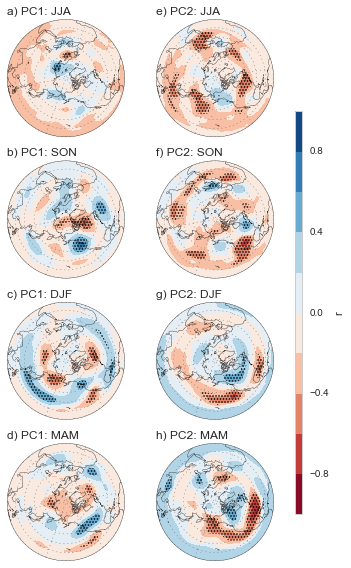

In [20]:
# Now lets see if we can speed things up for all season correlations with xarray.

with xr.open_dataset('./data/tcrv2_z500_season.nc') as hgt:
    hgt_anom = (hgt.sel(wy = slice(pd.to_datetime(WATER_YEAR['low'], format = '%Y'), 
                                   pd.to_datetime(WATER_YEAR['high'], format = '%Y')))
                   .z500
                   .groupby('season')
                   .apply(lambda x: x - x.mean(dim = 'wy'))
                   .copy())

hgt_corrs = point_corr(da = hgt_anom, pc_df = pc)
out = plot_point_corr(hgt_corrs, map_type = 'north_hemisphere')

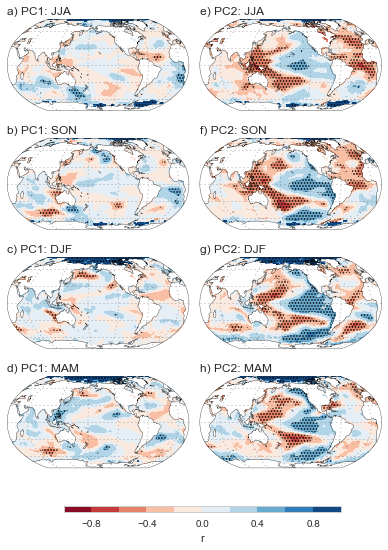

In [21]:
# Now lets see if we can speed things up for all season correlations with xarray.

with xr.open_dataset('./data/ersstv3b_season.nc') as field:
    sst_anom = (field.sel(wy = slice(pd.to_datetime(WATER_YEAR['low'], format = '%Y'), 
                                       pd.to_datetime(WATER_YEAR['high'], format = '%Y')))
                     .sst
                     .groupby('season')
                     .apply(lambda x: x - x.mean(dim = 'wy'))
                     .copy())

sst_corrs = point_corr(da = sst_anom, pc_df = pc)
out = plot_point_corr(sst_corrs, map_type = 'global')

# Composite maps

In [22]:
# Below is somewhat experimental. Need to check these answers.

In [23]:
def field_ttest(da, pc_df):
    season = ['JJA-1', 'SON-1', 'DJF', 'MAM']
    pc_dim = ['PC1', 'PC2']
    out_lat = da['lat'].values
    out_lon = da['lon'].values
    out_shape = (len(pc_dim), len(season), len(out_lat), len(out_lon))
    out = xr.Dataset({'dif': (['PC','season', 'lat', 'lon'], np.zeros(out_shape)),
                      'p': (['PC','season', 'lat', 'lon'], np.zeros(out_shape))},
                    coords = {'PC': pc_dim,
                              'season': season,
                              'lon': out_lon,
                              'lat': out_lat})
    for pc_i in pc_dim:
        for seas_i in season:
            dif, p = tools.composite_ttest(pc_df[pc_i].values, da.sel(season = seas_i).values)
            out['dif'].loc[dict(PC = pc_i, season= seas_i)] = dif
            out['p'].loc[dict(PC = pc_i, season= seas_i)] = p
    return out

def plot_field_ttest(ds, map_type):
    """
    """
    assert map_type in ['north_hemisphere', 'global']

    proj = {'north_hemisphere': ccrs.LambertAzimuthalEqualArea(central_longitude = -160,
                                                               central_latitude = 90),
            'global': ccrs.Robinson(central_longitude = -160)}
    subplot_kwargs = {'north_hemisphere': {'adjust': {'right': 1 - 0.15},
                                         'add_axes': [1 - 0.17, 0.1, 0.017, 0.7],
                                         'colorbar': {'orientation': 'vertical'}},
                      'global': {'adjust': {'bottom': 0.15},
                                 'add_axes': [0.17, 0.1, 0.7, 0.01],
                                 'colorbar': {'orientation': 'horizontal'}}
                     }

    pc_dim = ds['PC'].values
    season = ds['season'].values

#     divs = np.linspace(-30, 30, 21)
    divs = np.linspace(-2, 2, 11)
    alpha=[0, 0.05, 1]

    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mplpath.Path(verts * radius + center)

    plot_meta = [{'season': 'JJA-1',
                  'PC':     'PC1',
                  'title':  'a) PC1: JJA'},
                 {'season': 'JJA-1',
                  'PC':     'PC2',
                  'title':  'e) PC2: JJA'},
                 {'season': 'SON-1',
                  'PC':     'PC1',
                  'title':  'b) PC1: SON'},
                 {'season': 'SON-1',
                  'PC':     'PC2',
                  'title':  'f) PC2: SON'},
                 {'season': 'DJF',
                  'PC':     'PC1',
                  'title':  'c) PC1: DJF'},
                 {'season': 'DJF',
                  'PC':     'PC2',
                  'title':  'g) PC2: DJF'},
                 {'season': 'MAM',
                  'PC':     'PC1',
                  'title':  'd) PC1: MAM'},
                 {'season': 'MAM',
                  'PC':     'PC2',
                  'title':  'h) PC2: MAM'}]

    fig = plt.figure(figsize = (5.5, 8))
    for i in range(len(pc_dim) * len(season)):
        i_season = plot_meta[i]['season']
        i_pc = plot_meta[i]['PC']
        i_title = plot_meta[i]['title']
        ax = fig.add_subplot(len(season), len(pc_dim), i + 1, projection = proj[map_type])
        ax.coastlines()
        ax.gridlines(linestyle = 'dotted', color = '#696969', linewidth = 0.5)
        ds_crop = ds.sel(season = i_season, PC = i_pc)
        if map_type == 'north_hemisphere':
            ax.set_boundary(circle, transform = ax.transAxes)
            ds_crop = ds_crop.sel(lat = slice(90, 0))
        dif_crop = ds_crop['dif']
        p_crop = ds_crop['p']
        dif_cyc, lon_cyc = cartopy.util.add_cyclic_point(dif_crop.values, 
                                                       coord = dif_crop['lon'].values, 
                                                       axis = -1)
        p_cyc, lon_cyc = cartopy.util.add_cyclic_point(p_crop.values, 
                                                       coord = p_crop['lon'].values, 
                                                       axis = -1)
        ctf1 = ax.pcolormesh(lon_cyc, dif_crop.lat.values, dif_cyc,
                           cmap = plt.cm.RdBu, 
                           transform = ccrs.PlateCarree())
        ctf2 = ax.contourf(lon_cyc, p_crop.lat.values, p_cyc, alpha, 
                           colors = 'none', 
                           hatches = ['....', None], 
                           transform = ccrs.PlateCarree())
        ax.set_title(i_title, loc = 'left')
        
    fig.tight_layout()

    fig.subplots_adjust(**subplot_kwargs[map_type]['adjust'])
    cax = fig.add_axes(subplot_kwargs[map_type]['add_axes'])
    cb = plt.colorbar(ctf1, cax = cax, **subplot_kwargs[map_type]['colorbar'])
    cb.set_label('height anomaly difference(m)')
    
    return fig

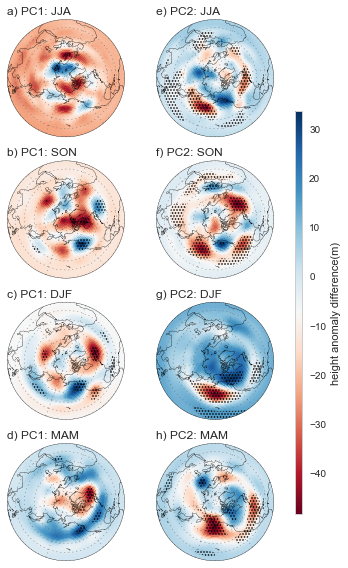

In [24]:
with xr.open_dataset('./data/tcrv2_z500_season.nc') as hgt:
    hgt_anom = (hgt.sel(wy = slice(pd.to_datetime(WATER_YEAR['low'], format = '%Y'), 
                                   pd.to_datetime(WATER_YEAR['high'], format = '%Y')))
                   .z500
                   .groupby('season')
                   .apply(lambda x: x - x.mean(dim = 'wy'))
                   .copy())

hgt_ttest = field_ttest(da = hgt_anom, pc_df = pc)
out = plot_field_ttest(hgt_ttest, map_type = 'north_hemisphere')

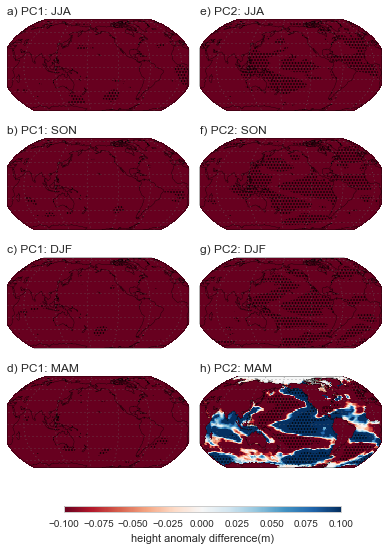

In [25]:
# Now lets see if we can speed things up for all season correlations with xarray.

with xr.open_dataset('./data/ersstv3b_season.nc') as field:
    sst_anom = (field.sel(wy = slice(pd.to_datetime(WATER_YEAR['low'], format = '%Y'), 
                                       pd.to_datetime(WATER_YEAR['high'], format = '%Y')))
                     .sst
                     .groupby('season')
                     .apply(lambda x: x - x.mean(dim = 'wy'))
                     .copy())

sst_ttest = field_ttest(da = sst_anom, pc_df = pc)
out = plot_field_ttest(sst_ttest, map_type = 'global')